train loss: 9.43e-03 | test loss: 2.78e-02 | reg: 3.47e+00 : 100%|██| 90/90 [00:19<00:00,  4.72it/s]


fixing (0,0,0) with 1/sqrt(x), r2=0.9937055706977844
fixing (0,0,1) with erfc, r2=0.9874909520149231
fixing (0,1,0) with erfc, r2=0.5642367601394653
fixing (0,1,1) with erfc, r2=0.9985162615776062
fixing (1,0,0) with erfc, r2=0.9979516267776489
fixing (1,0,1) with 1/sqrt(x), r2=0.8818092942237854
fixing (1,1,0) with erfc, r2=0.7093274593353271
fixing (1,1,1) with erfc, r2=0.14341650903224945
fixing (2,0,0) with erfc, r2=0.9995192885398865
fixing (2,1,0) with 1/sqrt(x), r2=0.22501768171787262
Discovered Symbolic Formula:
[40.74 - 12.08*erfc(-1.17*erfc(0.05*erfc(-19.9) - 1.45 + 1.12/sqrt(x_1 + 0.12)) - 2.3*erfc(0.48*erfc(-14.29) + 1.47*erfc(14.43*x_1 - 1.42) - 4.65) + 5.63)]
Mean Absolute Error (MAE): 0.8663990296175382
Mean Squared Error (MSE): 0.9236604625260273
R-squared (R²): 0.9709965682989096


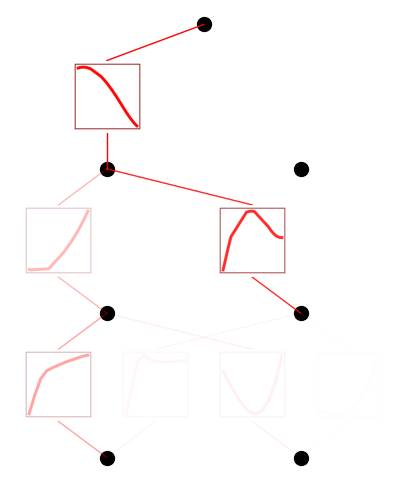

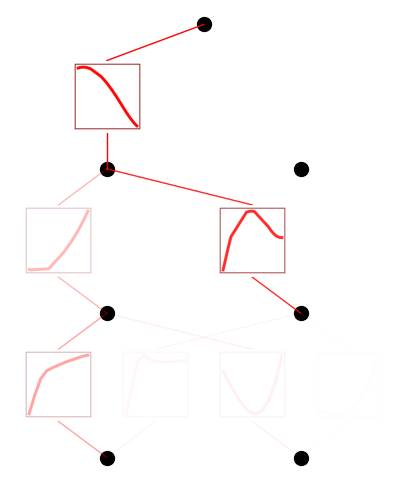

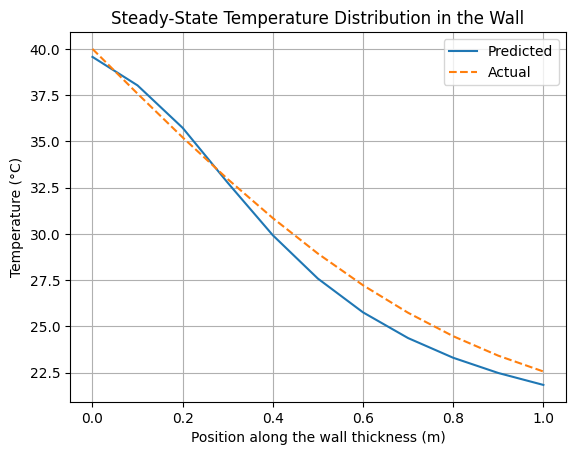

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from sympy import symbols, sympify
from scipy.special import erfc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from kan import KAN, add_symbolic

# Parameters
alpha = 2.5e-6
T0 = 20
T1 = 40
L = 1
dx = 0.1
dt = 1800
tMax = 86400
W = 30

# Time and space grid
x = np.arange(0, L + dx, dx)
t = np.arange(dt, tMax + dt, dt)

# Initialize temperature data storage
TemperatureData = np.zeros((len(t), len(x)))

# Compute temperature distribution and store results
for k in range(len(t)):
    TemperatureData[k, :] = T0 + (T1 - T0) * erfc(x / (2 * np.sqrt(alpha * t[k])))

# Prepare the data
x_data = np.array([[x_val, t_val] for t_val in t for x_val in x])
y_data = TemperatureData.flatten()

# Normalize the data
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0)
y_mean = np.mean(y_data)
y_std = np.std(y_data)

x_data_normalized = (x_data - x_mean) / x_std
y_data_normalized = (y_data - y_mean) / y_std

# Convert to tensors
x_tensor = torch.tensor(x_data_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y_data_normalized, dtype=torch.float32).unsqueeze(1)

# Split dataset into training and test sets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# Create the dataset dictionary as expected by KAN
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Add erfc to the symbolic library
add_symbolic('erfc', torch.special.erfc)

# Train the model using the tutorial's approach
model = KAN(width=[2, 2, 2, 1], grid=5, k=3, seed=0)
model.train(dataset, opt="LBFGS", steps=90, lamb=0.001, lamb_entropy=1.0)

# Automatically set activation functions to be symbolic
lib = ['x', '1/sqrt(x)', 'erfc']
model.auto_symbolic(lib=lib)

# Prune the model
model.prune()

# Plot the model
model.plot()
model.plot(mask=True)

# Obtain the symbolic formula and denormalize it
symbolic_formula, x0 = model.symbolic_formula(normalizer=[x_mean, x_std], output_normalizer=[[y_mean], [y_std]])

print("Discovered Symbolic Formula:")
print(symbolic_formula)

# Evaluate the final accuracy of the prediction
x_test = np.array([[x_val, tMax] for x_val in x])  # Use the final time step for testing
x_test_normalized = (x_test - x_mean) / x_std
x_test_tensor = torch.tensor(x_test_normalized, dtype=torch.float32)

predicted_temperature_normalized = model(x_test_tensor).detach().numpy().flatten()
predicted_temperature = predicted_temperature_normalized * y_std + y_mean

# Calculate metrics
mae = mean_absolute_error(TemperatureData[-1, :], predicted_temperature)
mse = mean_squared_error(TemperatureData[-1, :], predicted_temperature)
r2 = r2_score(TemperatureData[-1, :], predicted_temperature)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# Create output directory for plots
outputDir = 'TemperaturePlots'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

# Plot predicted temperature distribution
plt.figure()
plt.plot(x, predicted_temperature, label='Predicted')
plt.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')
plt.xlabel('Position along the wall thickness (m)')
plt.ylabel('Temperature (°C)')
plt.title('Steady-State Temperature Distribution in the Wall')
plt.legend()
plt.grid(True)
plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
plt.show()


In [4]:
print("Discovered Symbolic Formula (Normalized):")
model.symbolic_formula()[0][0]

Discovered Symbolic Formula (Normalized):


2.07 - 1.85*erfc(-2.3*erfc(1.47*erfc(4.56*x_1 + 5.8) + 0.48*erfc(4.13*x_2 - 6.99) - 4.65) - 1.17*erfc(0.05*erfc(5.62*x_2 - 9.96) - 1.45 + 1.43/sqrt(0.51*x_1 + 1)) + 5.63)